In [1]:
import pandas as pd
import numpy as np
import random
import altair as alt
import plotly.graph_objects as go
import requests
import inspect
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotify_tools
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.express as px
import pyvis
from pyvis import network as net
from itertools import combinations
from community import community_louvain
from copy import deepcopy
import time

In [2]:
# storing the credentials:
#
CLIENT_ID = "5c839bef0e594210be17d3124457bf3f"
CLIENT_SECRET = "7cd66cba016842faba09cb55eaed8050"
my_username = "lzsfootball"

# instantiating the client.  This 'sp' version of the client is used repeatedly below
# source: Max Hilsdorf (https://towardsdatascience.com/how-to-create-large-music-datasets-using-spotipy-40e7242cc6a6)
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Using Spotify Query

In [3]:
creator_id = "lzsfootball"
playlist_id = "1hTUFxr380FuNNYHpynyzy"

# playlist_tracks(user_id: String, playlist_id: String): json_dict
playlist_tracks = pd.DataFrame(sp.user_playlist_tracks(creator_id, playlist_id))
playlist_tracks

,href,items,limit,next,offset,previous,total
0,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:42:39Z', 'added_by...",100,None,0,None,10
1,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:42:42Z', 'added_by...",100,None,0,None,10
2,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:43:22Z', 'added_by...",100,None,0,None,10
3,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:44:56Z', 'added_by...",100,None,0,None,10
4,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:45:31Z', 'added_by...",100,None,0,None,10
5,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:46:20Z', 'added_by...",100,None,0,None,10
6,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:47:14Z', 'added_by...",100,None,0,None,10
7,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:48:01Z', 'added_by...",100,None,0,None,10
8,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:50:00Z', 'added_by...",100,None,0,None,10
9,https://api.spotify.com/v1/playlists/1hTUFxr38...,"{'added_at': '2023-10-06T17:51:32Z', 'added_by...",100,None,0,None,10


In [4]:
def analyze_playlist(creator, playlist_id, spotipy_client):
    playlist_features_list = ["artist", "album", "track_name",
                              "danceability", "energy", "key", "loudness", "mode", "speechiness",
                              "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"] # removed track_id
    playlist_df = pd.DataFrame(columns=playlist_features_list)

    playlist_features = {}

    playlist = spotipy_client.user_playlist_tracks(creator, playlist_id)["items"]
    for track in playlist:
        playlist_features["artist"] = track["track"]["album"]["artists"][0]["name"]
        playlist_features["album"] = track["track"]["album"]["name"]
        playlist_features["track_name"] = track["track"]["name"]
        playlist_features["track_id"] = track["track"]["id"]

        audio_features = spotipy_client.audio_features(playlist_features["track_id"])[0]
        for feature in playlist_features_list[3:]: # changed from 4 to 3 to fix error caused by removing track_id from list of features
            playlist_features[feature] = audio_features[feature]

        track_df = pd.DataFrame(playlist_features, index=[playlist_features['track_id']]) # changed index from automatically being 0 to being the track_id
        playlist_df = pd.concat([playlist_df, track_df], ignore_index=False) # changed ignore_index from True to False

    return playlist_df

In [5]:
df = analyze_playlist(creator_id, playlist_id, sp)
print(df)
print(df.at['5gRcv46AMTrosmTOqrOV3Q', 'liveness'])
print(type(df.at['5gRcv46AMTrosmTOqrOV3Q', 'liveness']))
x = df.loc['5gRcv46AMTrosmTOqrOV3Q']
got = x.get('liveness')
print(got)

                                              artist  \
5gRcv46AMTrosmTOqrOV3Q                       Nirvana   
70LcF31zb1H0PyJoS1Sx1r                     Radiohead   
065bY5WrLvI3NN9VCK0QLe                   Oliver Tree   
6Al4oITGudbYvcBzO65ah6                         Kyuss   
25aNJcqUnZmEKBmPhW9I82                     Kate Nash   
3sXaTInkrXe5YEaa6ZYr1S                     Lil Wayne   
3OmhbyRDJDm1zhfVEV7d0w             The Murderburgers   
22ML0MuFKfw16WejbxsLOy                   Pat Benatar   
2UiUTpQkTCmE1OX6senl6j                     Green Day   
2khc6kEG4eBvYN1GvR6R97  The Brian Jonestown Massacre   

                                           album      track_name  \
5gRcv46AMTrosmTOqrOV3Q                  In Utero            Dumb   
70LcF31zb1H0PyJoS1Sx1r               Pablo Honey           Creep   
065bY5WrLvI3NN9VCK0QLe         Ugly is Beautiful            Jerk   
6Al4oITGudbYvcBzO65ah6                    Wretch  Son of a Bitch   
25aNJcqUnZmEKBmPhW9I82            Made of B

In [6]:
def get_song_ids(tracks: pd.DataFrame) -> dict:     # Parameter is a dataframe, output is a dict
    """Returns the Spotify song IDs contained in the playlist dataframe, matched with the song titles to make them easy to identify"""
    song_ids = {}       # Empty dict to contain all outputted song ids
    for track in tracks['items']:           # Iterate through tracks in dataframe
        song_ids[track['track']['name']] = track['track']['id']          # add song id to list
    return song_ids    # return song ids

print(get_song_ids(playlist_tracks))

{'Dumb': '5gRcv46AMTrosmTOqrOV3Q', 'Creep': '70LcF31zb1H0PyJoS1Sx1r', 'Jerk': '065bY5WrLvI3NN9VCK0QLe', 'Son of a Bitch': '6Al4oITGudbYvcBzO65ah6', 'Dickhead': '25aNJcqUnZmEKBmPhW9I82', 'Snitch': '3sXaTInkrXe5YEaa6ZYr1S', 'Moron': '3OmhbyRDJDm1zhfVEV7d0w', 'Heartbreaker': '22ML0MuFKfw16WejbxsLOy', 'Jackass': '2UiUTpQkTCmE1OX6senl6j', 'Fucker': '2khc6kEG4eBvYN1GvR6R97'}


In [122]:
playlist_df

,artist,album,track_name,danceability,energy,key,loudness,mode,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_id
5gRcv46AMTrosmTOqrOV3Q,Nirvana,In Utero,Dumb,0.697,0.395,6,-13.580,1,0.0281,0.653000,0.1730,0.876,113.589,151893,4,5gRcv46AMTrosmTOqrOV3Q
70LcF31zb1H0PyJoS1Sx1r,Radiohead,Pablo Honey,Creep,0.515,0.430,7,-9.935,1,0.0372,0.000133,0.1290,0.104,91.844,238640,4,70LcF31zb1H0PyJoS1Sx1r
065bY5WrLvI3NN9VCK0QLe,Oliver Tree,Ugly is Beautiful,Jerk,0.521,0.707,9,-4.101,0,0.0428,0.000164,0.2270,0.298,159.824,135021,4,065bY5WrLvI3NN9VCK0QLe
6Al4oITGudbYvcBzO65ah6,Kyuss,Wretch,Son of a Bitch,0.456,0.700,5,-13.014,1,0.0464,0.046900,0.1820,0.471,101.023,363307,4,6Al4oITGudbYvcBzO65ah6
25aNJcqUnZmEKBmPhW9I82,Kate Nash,Made of Bricks,Dickhead,0.735,0.508,11,-8.129,0,0.1400,0.000002,0.1140,0.518,84.931,223000,4,25aNJcqUnZmEKBmPhW9I82
3sXaTInkrXe5YEaa6ZYr1S,Lil Wayne,Tha Carter,Snitch,0.844,0.723,6,-4.114,0,0.2830,0.000000,0.2260,0.625,102.907,235973,4,3sXaTInkrXe5YEaa6ZYr1S
3OmhbyRDJDm1zhfVEV7d0w,The Murderburgers,How to Ruin Your Life,Moron,0.530,0.978,0,-4.324,1,0.0629,0.000000,0.3270,0.537,125.961,104450,4,3OmhbyRDJDm1zhfVEV7d0w
22ML0MuFKfw16WejbxsLOy,Pat Benatar,In The Heat Of The Night,Heartbreaker,0.466,0.588,5,-10.666,0,0.0812,0.000010,0.0535,0.882,156.131,209360,4,22ML0MuFKfw16WejbxsLOy
2UiUTpQkTCmE1OX6senl6j,Green Day,Warning,Jackass,0.509,0.954,7,-2.903,1,0.0348,0.000000,0.0888,0.575,94.481,163040,4,2UiUTpQkTCmE1OX6senl6j
2khc6kEG4eBvYN1GvR6R97,The Brian Jonestown Massacre,Take It From The Man,Fucker,0.242,0.653,0,-6.012,1,0.0332,0.000000,0.5390,0.373,78.733,132400,4,2khc6kEG4eBvYN1GvR6R97


In [121]:
def compare_keys(key1: int, mode1: int, key2: int, mode2: int) -> float:
    """
    Returns how similar the key of 2 tracks is based on their relative positions in the circle of fifths.

    For example, C major and A minor both occupy the same position on the circle of fifths (position 0). G maj/E min is position 2. D maj/B min is position 3,
    and so on up to F maj/D min at position 11.

    This function uses key and mode information provided by Spotify to calculate the position of each track on the circle of fifths.
    The circle has 12 positions, so the minimum distance between two points is 0, and the maximum distance is 6, because the circle is bidirectional.
    The function returns a scalar from 0-1, where 1 represents the maximum distance and 0 the minimum. Thus, the result is 1/6 of the distance on the circle.
    """
    # Similar means similar audio feature values. Thus returning 0 means very similar, and 1 means very different.

    circle_pos_1 = (7 * key1) % 12      # increase of 1 on the Spotify scale = up a half step
                                        # but increase of a half step on the circle of fifths = up 7 positions (but max position is 11)

    if mode1 == 0:                                  # however, if the key is actually a minor key, need to shift back 3 positions (equivalent to up 9)
        circle_pos_1 = (circle_pos_1 + 9) % 12      # because, for example, C maj has position 0, but C min has position 9, on the circle of fifths

    circle_pos_2 = (7 * key2) % 12      # calculate the position on the circle of fifths for the other song in the same way
    if mode2 == 0:
        circle_pos_2 = (circle_pos_2 + 9) % 12

    circle_dist = abs(circle_pos_1 - circle_pos_2)      # calculate the distance between the 2 positions on the circle
    if circle_dist > 6:                                 # because circle is bidirectional, differences greater than 6 are actually closer than 6
        circle_dist = 12 - circle_dist

    return circle_dist / 6      # convert to 0-1 scalar


def similarity_dict(id1: str, id2: str, playlist_df: pd.DataFrame) -> dict:
    """Returns a dictionary with the similarity of each audio feature for the 2 given tracks. Smaller numbers mean more similar."""
    similarities = {}

    # A list of features to compare:
    features = ['danceability', 'energy', 'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo', 'key', 'mode']

    track1 = playlist_df.loc[id1] # variable containing all feature data from track 1
    track2 = playlist_df.loc[id2] # variable containing all feature data from track 2

    # Store all music feature data in dictionary form:
    # The important part of this code is converting everything to a number (not a string) that can be manipulated
    track1_features = {}
    track2_features = {}
    for feature in features:
        track1_features[feature] = track1.get(feature)
        track2_features[feature] = track2.get(feature)

    feature_similarities = {}
    for feature in features:
        if feature not in ['loudness', 'tempo', 'mode', 'key']:     # these features aren't stored as scalars, meaning their comparisons need to be handled differently
            # Compute the difference between the feature data for each track
            feature_similarities[feature] = abs(track1_features[feature] - track2_features[feature])

        if feature == 'loudness':
            feature_similarities[feature] = abs(track1_features[feature] - track2_features[feature]) * (1/60)  # loudness is stored -60 to 0, this converts the difference to a positive scalar
            # In rare cases, loudness falls outside the -60 to 0 range. If so, the code to scale down the difference between loudness to a scalar might result in a value over 1.
            # This code caps the maximum amount of difference at 1 - in other words, tracks that have over 60 dB of loudness difference are treated as having 60 dB of loudness difference.
            if feature_similarities[feature] > 1:
                feature_similarities[feature] = 1

        if feature == 'tempo':
            # Tempo is measured in BPM. This could be any positive integer, but most are within a range of 40-200 BPM.
            # For the purpose of comparison, tracks under 40 BPM are treated as having a BPM of 40. Tracks over 200 are treated as having a BPM of 200.
            # Thus, the maximum difference is 160, and the minimum is 0.
            # So to convert to a scalar, the difference between BPM is divided by 160.
            if track1_features[feature] < 40:
                track1_features[feature] = 40
            if track1_features[feature] > 200:
                track1_features[feature] = 200
            if track2_features[feature] < 40:
                track2_features[feature] = 40
            if track2_features[feature] > 200:
                track2_features[feature] = 200

            feature_similarities[feature] = abs(track1_features[feature] - track2_features[feature]) * (1/140)

        if feature == 'key':
            feature_similarities[feature] = compare_keys(track1_features['key'], track1_features['mode'], track2_features['key'], track2_features['mode'])

        if feature == 'mode':
            feature_similarities[feature] = float(abs(track1_features[feature] - track2_features[feature]))     # converted to float (from int) for uniformity, no practical effect

    return feature_similarities


def similarity_scalar_from_dict(feature_similarities: dict, **weights) -> float:
    """
    Returns a scalar from 0-1 that tells you how similar 2 songs are based on a mash-up of their audio features.
    By default, each audio feature is weighted equally in comparison (weight = 1). However, you can include a parameter for any audio feature you want.
    Setting this value to 0, for example, will give that feature no weight. Setting it to 4 will make that feature 4x as important as every other feature.
    Example usages:
        similarity_scalar(feature_similarities)
        similarity_scalar(feature_similarities, valence=4)
        similarity_scalar(feature_similarities, valence=4, mode=0, key=10)
    """

    # The scalar is computed as an average of all the similarities.
    total = 0                                                           # Stores the current sum of similarity differences
    total_weight = len(feature_similarities)                            # Stores the current sum of weights, by default = number of features * 1
    for similarity in feature_similarities.items():                     # Iterate through all audio features given (.items() iterates a tuple: (feature, similarity))
        try:                                                            # Act as if there's a given weight for this feature. Try to compute that.
            total += similarity[1] * weights[similarity[0]]             # Add this similarity times its special weight to the sum of similarities.
            total_weight += weights[similarity[0]]                      # Add the weight to the total weight. The sum of similarities is divided by this number.
        except KeyError:                                                # Base case: no weight was given for this feature
            total += similarity[1]                                      # Add the similarity for this feature to the total similarity variable

    # Divide the total similarity variable by the number of features
    # Changing weights of features essentially changes the number of features
    # In the data, 2 identical songs have a similarity average of 0.
    # However, it makes intuitive sense for similarity to be measured as 1 = identical, and 0 = completely different.
    # Hence, the value is inverted:
    return 1 - (total / total_weight)


def similarity_scalar(id1: str, id2: str, playlist_df: pd.DataFrame, **weights) -> float:
    """
    Overloads the similarity_scalar function to just take song ids and optional feature weights
    But since function overloading isn't a thing in Python (why???) they're actually different functions.
    """
    return similarity_scalar_from_dict(similarity_dict(id1, id2, playlist_df), **weights)

# Since we already wrote a function that returns a dictionary associating a song title with its ID, we'll use that
song_ids = get_song_ids(playlist_tracks)
# We need to analyze the playlist:
playlist_df = analyze_playlist(creator_id, playlist_id, sp)
# Compare 2 songs with matching keys based on circle of fifths:
comp1 = similarity_dict(song_ids['Fucker'], song_ids['Jerk'], playlist_df)
# Compare a song to itself:
comp2 = similarity_dict(song_ids['Dumb'], song_ids['Dumb'], playlist_df)

# See comparison breakdowns:
print(comp1)
print(comp2)

# See similarity scalars:
print(similarity_scalar(song_ids['Fucker'], song_ids['Jerk'], playlist_df))     # A scalar for comp1 from before
print(similarity_scalar(song_ids['Fucker'], song_ids['Jerk'], playlist_df, instrumentalness=2000))      # Weight instrumentalness 2000x more important than everything else.
print(similarity_scalar(song_ids['Dumb'], song_ids['Dumb'], playlist_df))       # A scalar for comp2 from before

{'danceability': 0.279, 'energy': 0.05399999999999994, 'instrumentalness': 0.000164, 'liveness': 0.31200000000000006, 'valence': 0.07500000000000001, 'loudness': 0.03184999999999999, 'tempo': 0.5792214285714287, 'key': 0.0, 'mode': 1.0}
{'danceability': 0.0, 'energy': 0.0, 'instrumentalness': 0.0, 'liveness': 0.0, 'valence': 0.0, 'loudness': 0.0, 'tempo': 0.0, 'key': 0.0, 'mode': 0.0}
0.7409738412698412
0.9986764203939416
1.0


In [123]:
similarity_dict(song_ids['Fucker'], song_ids['Jerk'], playlist_df)

{'danceability': 0.279,
 'energy': 0.05399999999999994,
 'instrumentalness': 0.000164,
 'liveness': 0.31200000000000006,
 'valence': 0.07500000000000001,
 'loudness': 0.03184999999999999,
 'tempo': 0.5792214285714287,
 'key': 0.0,
 'mode': 1.0}

## Class Data

In [8]:
class_playlists_csv = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQ4QCeBZ0m8k4829vHneGi50Vt9_cJTOJzlW87YqAK7DCKl4RMtjefztShCi_mf7Km4DmwLcCaKBp96/pub?output=csv'

class_playlists = pd.read_csv(class_playlists_csv)

In [9]:
class_playlists

,your_name,playlist_short_title,playlist_theme_in_a_short_sentence,your_spotify_user_id,playlist_id,possible_point_of_inquiry_for_this_list
0,Felicia Pursner,Rachel,Rachel is my friend that moved away and I am s...,31q5klg4ff7wfe2xydkj2qfbai3e,3G7quCcAFg2XoLfP67KAz0,I would be interested to see the most common w...
1,Felicia Pursner,21,About growing up and being a mess,31q5klg4ff7wfe2xydkj2qfbai3e,39HTY1maJNsZ38f0PxYTCn,Comparing the key to the tempo (does a minor k...
2,Felicia Pursner,RUTH Covers,Running up that hill 10x,31q5klg4ff7wfe2xydkj2qfbai3e,6LGNXpHmGXfuBfMP3xlkgd,Which is the most danceable
3,Logan Griffin,fall compressed,Songs that are becoming essential to this Fall...,si13w4vxra7rr13akrgyjqna1,5cYM4qJ240rXUpFkHtOOML,Similarities like acousticness and speechiness...
4,Logan Griffin,bright - dnd character,Base playlist for a DnD character I had last y...,si13w4vxra7rr13akrgyjqna1,2mhU6pRVXoBUV4NpPzwXG5,Common lyrics/themes. What is communicated abo...
...,...,...,...,...,...,...
67,Virginia Do,my superwoman girlfriend,title,31dgylwwt5xotlt3mvwdrlaoqzee,0W0aM5sxkXvE61zbKvPR3h,I'd be interested in the common words/lyrics a...
68,Virginia Do,me and my sib,me and my younger brother's shared asian gener...,31dgylwwt5xotlt3mvwdrlaoqzee,6g5nJwIKMvO5S6SDt6JeAB,The way piecing together non-narrative vibes i...
69,Amanda Edelmayer,Mental Breakdown Bops,songs that sound like mental breakdowns,MilkTeaHoneyy,72pOht0sjEPlgpCPbwUNfS,What makes these songs sound like mental break...
70,Amanda Edelmayer,The 2020's,a collection of ElectroSwing songs that I like,MilkTeaHoneyy,6tf3BsN0WB51IsU7PLxLgv,How do these songs blend the old and the new? ...


In [10]:
class_audio_data = pd.read_csv('https://bit.ly/our_spotify_list_audio_data')

In [43]:
class_audio_data

,track_id,track_title,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,playlist_title
0,2aDk1KkyB7ieSwwEDXCHJg,The Mind Electric,Miracle Musical,0.227,0.431,7,-9.527,0,0.0432,0.66600,...,0.575,76.986,audio_features,2aDk1KkyB7ieSwwEDXCHJg,spotify:track:2aDk1KkyB7ieSwwEDXCHJg,https://api.spotify.com/v1/tracks/2aDk1KkyB7ie...,https://api.spotify.com/v1/audio-analysis/2aDk...,373359,4,amanda_edelmayer_mental_breakdown_bops
1,7JTGwb6ug0z15F5roNLE0s,Two Time,Jack Stauber's Micropop,0.832,0.346,0,-9.640,1,0.0360,0.11200,...,0.688,98.512,audio_features,7JTGwb6ug0z15F5roNLE0s,spotify:track:7JTGwb6ug0z15F5roNLE0s,https://api.spotify.com/v1/tracks/7JTGwb6ug0z1...,https://api.spotify.com/v1/audio-analysis/7JTG...,139851,4,amanda_edelmayer_mental_breakdown_bops
2,1dXivQjVkgLUytJ7PGdlod,What's Gonna Happen,Sarah Stiles,0.689,0.676,11,-8.310,1,0.2880,0.67800,...,0.865,177.847,audio_features,1dXivQjVkgLUytJ7PGdlod,spotify:track:1dXivQjVkgLUytJ7PGdlod,https://api.spotify.com/v1/tracks/1dXivQjVkgLU...,https://api.spotify.com/v1/audio-analysis/1dXi...,187413,4,amanda_edelmayer_mental_breakdown_bops
3,67VxWciiaYZYy3NTlyCtp7,Cigarette Ahegao,Penelope Scott,0.654,0.285,5,-13.379,0,0.0375,0.09660,...,0.148,82.997,audio_features,67VxWciiaYZYy3NTlyCtp7,spotify:track:67VxWciiaYZYy3NTlyCtp7,https://api.spotify.com/v1/tracks/67VxWciiaYZY...,https://api.spotify.com/v1/audio-analysis/67Vx...,183992,4,amanda_edelmayer_mental_breakdown_bops
4,5YIyPIZseBVqumEiZfsv41,You Stupid Bitch (feat. Rachel Bloom),Crazy Ex-Girlfriend Cast,0.442,0.527,7,-4.982,0,0.0314,0.62300,...,0.453,102.248,audio_features,5YIyPIZseBVqumEiZfsv41,spotify:track:5YIyPIZseBVqumEiZfsv41,https://api.spotify.com/v1/tracks/5YIyPIZseBVq...,https://api.spotify.com/v1/audio-analysis/5YIy...,142817,3,amanda_edelmayer_mental_breakdown_bops
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,4zQuwW24dweWcaX0fEJkP2,You Know I'm No Good,Amy Winehouse,0.705,0.806,9,-3.607,1,0.0309,0.01320,...,0.734,103.383,audio_features,4zQuwW24dweWcaX0fEJkP2,spotify:track:4zQuwW24dweWcaX0fEJkP2,https://api.spotify.com/v1/tracks/4zQuwW24dweW...,https://api.spotify.com/v1/audio-analysis/4zQu...,256947,4,owen_yaggy_ice_cream_shop
700,33X9miK4Xz7pNeVrc9RITG,Ready to Start,Arcade Fire,0.277,0.934,9,-4.672,1,0.0382,0.11700,...,0.519,188.797,audio_features,33X9miK4Xz7pNeVrc9RITG,spotify:track:33X9miK4Xz7pNeVrc9RITG,https://api.spotify.com/v1/tracks/33X9miK4Xz7p...,https://api.spotify.com/v1/audio-analysis/33X9...,255907,4,owen_yaggy_ice_cream_shop
701,2MLHyLy5z5l5YRp7momlgw,Island In The Sun,Weezer,0.654,0.810,4,-6.260,0,0.0288,0.00719,...,0.661,114.623,audio_features,2MLHyLy5z5l5YRp7momlgw,spotify:track:2MLHyLy5z5l5YRp7momlgw,https://api.spotify.com/v1/tracks/2MLHyLy5z5l5...,https://api.spotify.com/v1/audio-analysis/2MLH...,200307,4,owen_yaggy_ice_cream_shop
702,4sebUbjqbcgDSwG6PbSGI0,Come a Little Closer,Cage The Elephant,0.440,0.778,1,-1.786,0,0.0327,0.02650,...,0.304,148.038,audio_features,4sebUbjqbcgDSwG6PbSGI0,spotify:track:4sebUbjqbcgDSwG6PbSGI0,https://api.spotify.com/v1/tracks/4sebUbjqbcgD...,https://api.spotify.com/v1/audio-analysis/4seb...,229347,4,owen_yaggy_ice_cream_shop


In [62]:
column_list = ['track_id', 'track_title', 'artist_name', 'danceability','energy', 'key','loudness','mode', 'instrumentalness', 'speechiness','acousticness', 'liveness', 'valence','tempo','playlist_title']
class_audio_short = class_audio_data[column_list]
class_audio_short

,track_id,track_title,artist_name,danceability,energy,key,loudness,mode,instrumentalness,speechiness,acousticness,liveness,valence,tempo,playlist_title
0,2aDk1KkyB7ieSwwEDXCHJg,The Mind Electric,Miracle Musical,0.227,0.431,7,-9.527,0,0.023900,0.0432,0.66600,0.1260,0.575,76.986,amanda_edelmayer_mental_breakdown_bops
1,7JTGwb6ug0z15F5roNLE0s,Two Time,Jack Stauber's Micropop,0.832,0.346,0,-9.640,1,0.000013,0.0360,0.11200,0.0945,0.688,98.512,amanda_edelmayer_mental_breakdown_bops
2,1dXivQjVkgLUytJ7PGdlod,What's Gonna Happen,Sarah Stiles,0.689,0.676,11,-8.310,1,0.000027,0.2880,0.67800,0.0481,0.865,177.847,amanda_edelmayer_mental_breakdown_bops
3,67VxWciiaYZYy3NTlyCtp7,Cigarette Ahegao,Penelope Scott,0.654,0.285,5,-13.379,0,0.021600,0.0375,0.09660,0.1050,0.148,82.997,amanda_edelmayer_mental_breakdown_bops
4,5YIyPIZseBVqumEiZfsv41,You Stupid Bitch (feat. Rachel Bloom),Crazy Ex-Girlfriend Cast,0.442,0.527,7,-4.982,0,0.000000,0.0314,0.62300,0.2970,0.453,102.248,amanda_edelmayer_mental_breakdown_bops
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,4zQuwW24dweWcaX0fEJkP2,You Know I'm No Good,Amy Winehouse,0.705,0.806,9,-3.607,1,0.004280,0.0309,0.01320,0.0701,0.734,103.383,owen_yaggy_ice_cream_shop
700,33X9miK4Xz7pNeVrc9RITG,Ready to Start,Arcade Fire,0.277,0.934,9,-4.672,1,0.024200,0.0382,0.11700,0.0692,0.519,188.797,owen_yaggy_ice_cream_shop
701,2MLHyLy5z5l5YRp7momlgw,Island In The Sun,Weezer,0.654,0.810,4,-6.260,0,0.002510,0.0288,0.00719,0.1650,0.661,114.623,owen_yaggy_ice_cream_shop
702,4sebUbjqbcgDSwG6PbSGI0,Come a Little Closer,Cage The Elephant,0.440,0.778,1,-1.786,0,0.000001,0.0327,0.02650,0.1510,0.304,148.038,owen_yaggy_ice_cream_shop


In [129]:
class_audio_short.loc['Jerk' == class_audio_short['track_title']]

,track_id,track_title,artist_name,danceability,energy,key,loudness,mode,instrumentalness,speechiness,acousticness,liveness,valence,tempo,playlist_title
215,065bY5WrLvI3NN9VCK0QLe,Jerk,Oliver Tree,0.521,0.707,9,-4.101,0,0.000164,0.0428,0.0327,0.227,0.298,159.824,luke_sheppard_insults


In [13]:
class_audio_short['key'][0]

7

In [14]:
def compare_keys(key1: int, mode1: int, key2: int, mode2: int) -> float:
    """
    Returns how similar the key of 2 tracks is based on their relative positions in the circle of fifths.

    For example, C major and A minor both occupy the same position on the circle of fifths (position 0). G maj/E min is position 2. D maj/B min is position 3,
    and so on up to F maj/D min at position 11.

    This function uses key and mode information provided by Spotify to calculate the position of each track on the circle of fifths.
    The circle has 12 positions, so the minimum distance between two points is 0, and the maximum distance is 6, because the circle is bidirectional.
    The function returns a scalar from 0-1, where 1 represents the maximum distance and 0 the minimum. Thus, the result is 1/6 of the distance on the circle.
    """
    # Similar means similar audio feature values. Thus returning 0 means very similar, and 1 means very different

    circle_pos_1 = (7 * key1) % 12      # increase of 1 on the Spotify scale = up a half step
                                        # but increase of a half step on the circle of fifths = up 7 positions (but max position is 11)

    if mode1 == 0:                                  # however, if the key is actually a minor key, need to shift back 3 positions (equivalent to up 9)
        circle_pos_1 = (circle_pos_1 + 9) % 12      # because, for example, C maj has position 0, but C min has position 9, on the circle of fifths

    circle_pos_2 = (7 * key2) % 12      # calculate the position on the circle of fifths for the other song in the same way
    if mode2 == 0:
        circle_pos_2 = (circle_pos_2 + 9) % 12

    circle_dist = abs(circle_pos_1 - circle_pos_2)      # calculate the distance between the 2 positions on the circle
    if circle_dist > 6:                                 # because circle is bidirectional, differences greater than 6 are actually closer than 6
        circle_dist = 12 - circle_dist

    return circle_dist / 6      # convert to 0-1 scalar

In [18]:
def compare_keys_track(track_id_1, track_id_2, df_input):
    first_track = df_input.loc[df_input["track_id"] == track_id_1]
    second_track = df_input.loc[df_input["track_id"] == track_id_2]
    print(first_track)
    return compare_keys(int(first_track["key"]), int(first_track["mode"]), int(second_track["key"]), int(second_track["mode"]))
    

In [19]:
compare_keys_track('4XfI7M5gLwEY84gYiH4RDD','33X9miK4Xz7pNeVrc9RITG', class_audio_short)

                   track_id       track_title        artist_name  \
703  4XfI7M5gLwEY84gYiH4RDD  Devil's Advocate  The Neighbourhood   

     danceability  energy  key  loudness  mode  speechiness  acousticness  \
703         0.662   0.681   11    -8.152     0       0.0315        0.0321   

     valence   tempo             playlist_title  
703    0.864  98.004  owen_yaggy_ice_cream_shop  


0.16666666666666666

In [21]:
class_audio_short.get('track_id')

0      2aDk1KkyB7ieSwwEDXCHJg
1      7JTGwb6ug0z15F5roNLE0s
2      1dXivQjVkgLUytJ7PGdlod
3      67VxWciiaYZYy3NTlyCtp7
4      5YIyPIZseBVqumEiZfsv41
                ...          
699    4zQuwW24dweWcaX0fEJkP2
700    33X9miK4Xz7pNeVrc9RITG
701    2MLHyLy5z5l5YRp7momlgw
702    4sebUbjqbcgDSwG6PbSGI0
703    4XfI7M5gLwEY84gYiH4RDD
Name: track_id, Length: 704, dtype: object

In [162]:
class_audio_short.loc[703, 'track_title']

"Devil's Advocate"

In [194]:
class_audio_short.get('playlist_title')

0      amanda_edelmayer_mental_breakdown_bops
1      amanda_edelmayer_mental_breakdown_bops
2      amanda_edelmayer_mental_breakdown_bops
3      amanda_edelmayer_mental_breakdown_bops
4      amanda_edelmayer_mental_breakdown_bops
                        ...                  
699                 owen_yaggy_ice_cream_shop
700                 owen_yaggy_ice_cream_shop
701                 owen_yaggy_ice_cream_shop
702                 owen_yaggy_ice_cream_shop
703                 owen_yaggy_ice_cream_shop
Name: playlist_title, Length: 704, dtype: object

In [191]:
def similarity_dict(track_id_1: str, track_id_2: str, df_input) -> dict:
    """Returns a dictionary with the similarity of each audio feature for the 2 given tracks. Smaller numbers mean more similar."""

    # A list of features to compare:
    features = ['track_title', 'danceability', 'energy', 'loudness','instrumentalness', 'liveness', 'valence', 'tempo']
    first_track = df_input.loc[df_input["track_id"] == track_id_1] # variable containing all feature data from track 1
    second_track = df_input.loc[df_input["track_id"] == track_id_2] # variable containing all feature data from track 2
    # Store all music feature data in dictionary form:
    # The important part of this code is converting everything to a number (not a string) that can be manipulated
    first_track_features = {}
    second_track_features = {}
    for feature in features:
        first_track_features[feature] = first_track.get(feature)
        second_track_features[feature] = second_track.get(feature)
    

    feature_similarities = {}
    for feature in features:
        if feature in ['danceability', 'energy', 'instrumentalness', 'liveness', 'valence']:     # these features aren't stored as scalars, meaning their comparisons need to be handled differently
            # Compute the difference between the feature data for each track
            feature_similarities[feature] = abs(float(first_track_features[feature]) - float(second_track_features[feature]))
            
        if feature == 'loudness':
            feature_similarities[feature] = abs(float(first_track_features[feature]) - float(second_track_features[feature])) * (1/60)  # loudness is stored -60 to 0, this converts the difference to a positive scalar
            # In rare cases, loudness falls outside the -60 to 0 range. If so, the code to scale down the difference between loudness to a scalar might result in a value over 1.
            # This code caps the maximum amount of difference at 1 - in other words, tracks that have over 60 dB of loudness difference are treated as having 60 dB of loudness difference.
            if feature_similarities[feature] > 1:
                feature_similarities[feature] = 1

        if feature == 'tempo':
            # Tempo is measured in BPM. This could be any positive integer, but most are within a range of 40-200 BPM.
            # For the purpose of comparison, tracks under 40 BPM are treated as having a BPM of 40. Tracks over 200 are treated as having a BPM of 200.
            # Thus, the maximum difference is 160, and the minimum is 0.
            # So to convert to a scalar, the difference between BPM is divided by 160.
            first_track_features[feature] = float(first_track.get(feature))
            second_track_features[feature] = float(second_track.get(feature))
            
            if first_track_features[feature] < 40:
                first_track_features[feature] = 40
            if first_track_features[feature] > 200:
                first_track_features[feature] = 200
            if second_track_features[feature] < 40:
                second_track_features[feature] = 40
            if second_track_features[feature] > 200:
                second_track_features[feature] = 200

            feature_similarities[feature] = abs(first_track_features[feature] - second_track_features[feature]) * (1/140)

    return feature_similarities


In [183]:
comp_1 = similarity_dict('2khc6kEG4eBvYN1GvR6R97', '065bY5WrLvI3NN9VCK0QLe', class_audio_short)

In [192]:
comp_1

{'danceability': 0.279,
 'energy': 0.05399999999999994,
 'loudness': 0.03184999999999999,
 'instrumentalness': 0.000164,
 'liveness': 0.31200000000000006,
 'valence': 0.07500000000000001,
 'tempo': 0.5792214285714287}

In [187]:
def dict_to_list(dictionary):
    keys = []
    values = []
    
    for key in dictionary:
        keys.append(key)
        values.append(dictionary[key])
    return keys, values
radar_val = dict_to_list(comp_1)

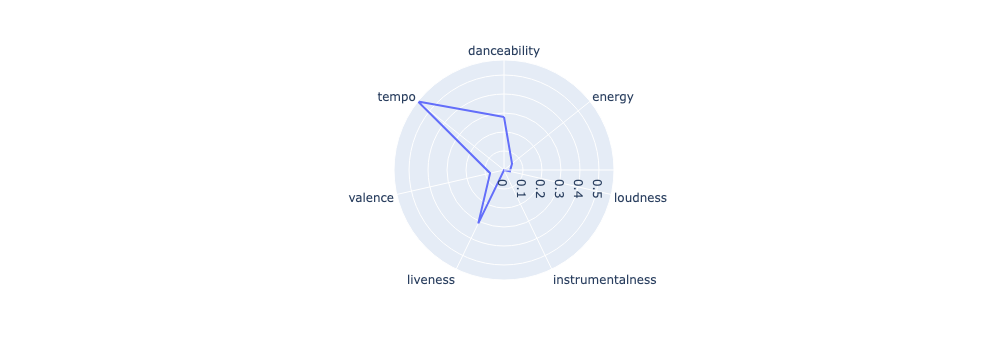

In [190]:
def make_radar(tuple_keys_val):
    df = pd.DataFrame(dict(
        r=tuple_keys_val[1],
        theta=tuple_keys_val[0]))
    fig = px.line_polar(df, r='r', theta='theta', line_close=True)
    fig.show()
make_radar(radar_val)

{'danceability': 0.279,
 'energy': 0.05399999999999994,
 'instrumentalness': 0.000164,
 'liveness': 0.31200000000000006,
 'valence': 0.07500000000000001,
 'loudness': 0.03184999999999999,
 'tempo': 0.5792214285714287,
 'key': 0.0,
 'mode': 1.0}

In [ ]:
if feature == 'key':
            feature_similarities[feature] = compare_keys(track1_features['key'], track1_features['mode'], track2_features['key'], track2_features['mode'])

        if feature == 'mode':
            feature_similarities[feature] = float(abs(track1_features[feature] - track2_features[feature]))     # converted to float (from int) for uniformity, no practical effect
